# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


C:\Users\kaizi\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
data_dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\flower_photos\\flower_photos'

In [4]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [5]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Loading data

In [6]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Desired dimensions
target_height = 224
target_width = 224

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [7]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [8]:
print(f'Training images shape: {len(train_images)}')
print(f'Validation images shape: {len(validation_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2496
Validation images shape: 440
Testing images shape: 734


In [9]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

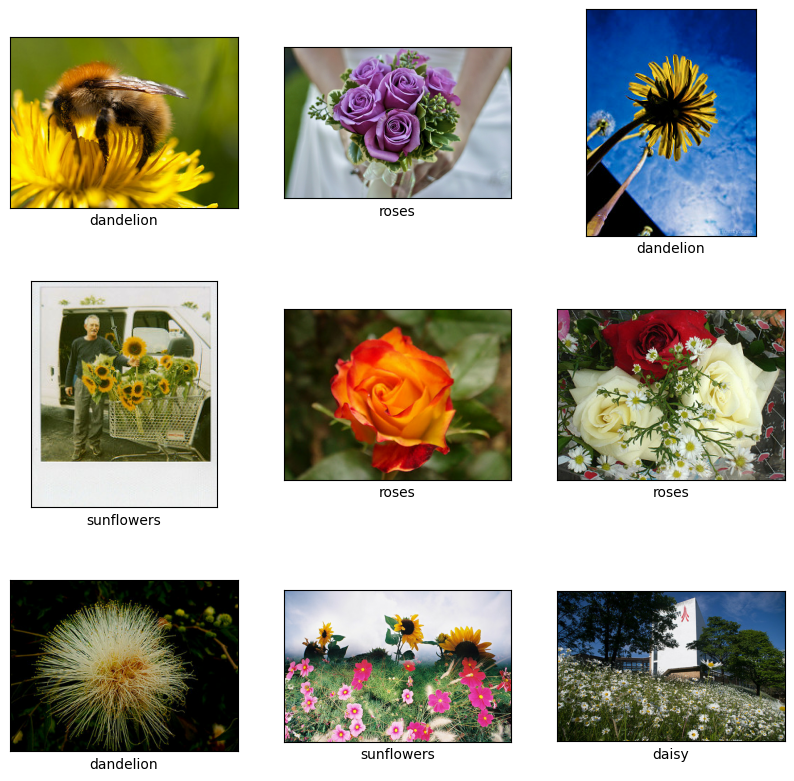

In [10]:
show_images(train_images, 9, train_labels)

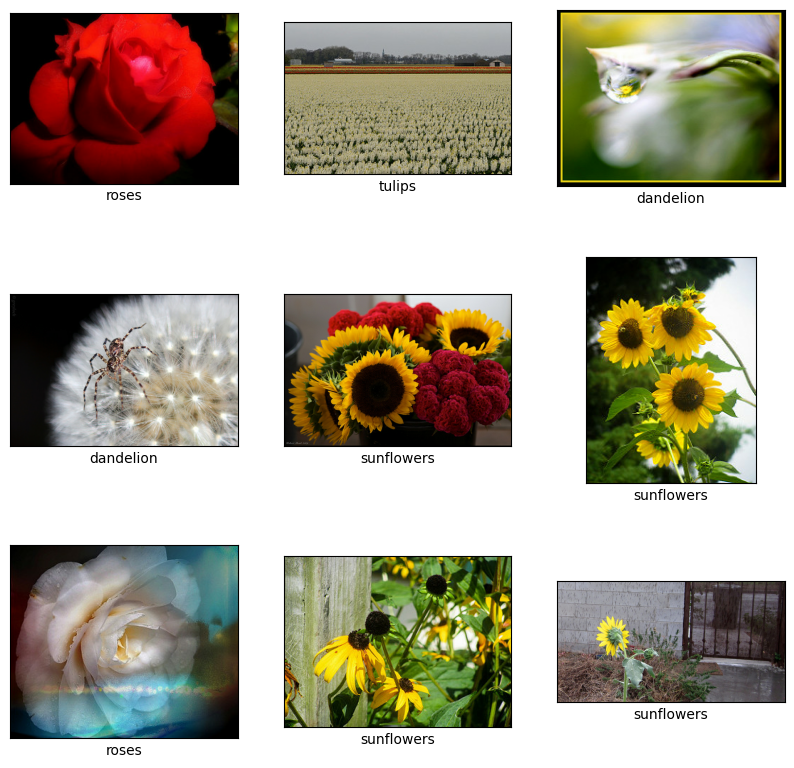

In [11]:
show_images(validation_images, 9, validation_labels)

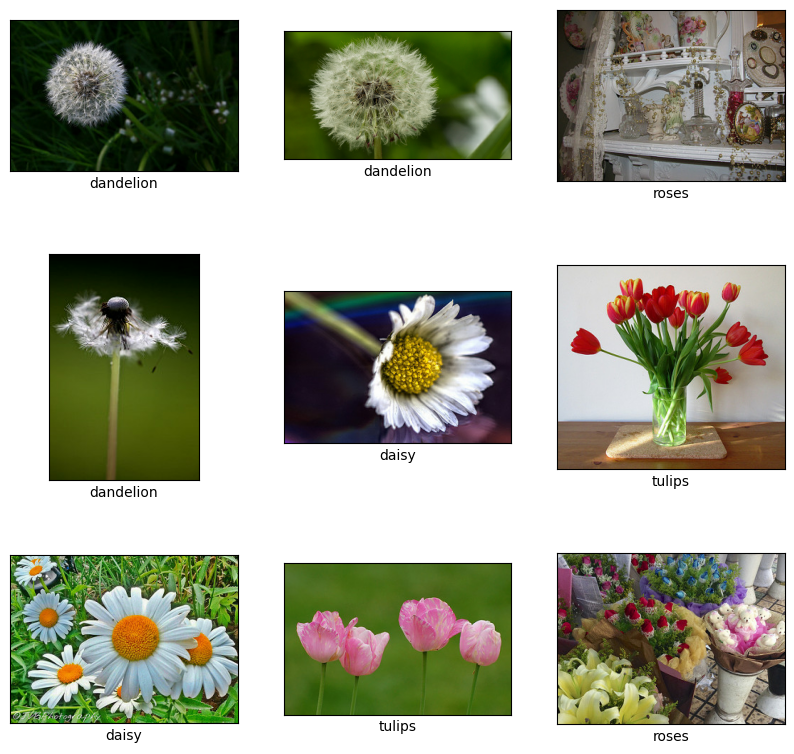

In [12]:
show_images(test_images, 9, test_labels)

### Preprocessing Images

In [13]:
def string_to_tensor(str):
   index = class_names.index(str)
   return tf.convert_to_tensor(index, dtype=tf.int64)

In [14]:
from keras.applications.vgg16 import preprocess_input

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(244, 244),
    tf.keras.layers.Lambda(preprocess_input)
])

In [15]:
def transform_images(images, labels):
  labels = [string_to_tensor(s) for s in labels]
  image_set = [preprocess(x) for x in images]
  dataset = tf.data.Dataset.from_tensor_slices((image_set, labels))
  return dataset

In [16]:
def show_dataset_images(dataset):
  plt.figure(figsize=(12, 10))
  index = 0
  for image, label in dataset.take(9):
      index += 1
      plt.subplot(3, 3, index)
      
       # Reverse preprocessing for VGG16 visualization
      image = image.numpy()
      image[..., 0] += 103.939  # Add mean for B channel
      image[..., 1] += 116.779  # Add mean for G channel
      image[..., 2] += 123.68   # Add mean for R channel
      image = np.clip(image, 0, 255).astype(np.uint8)
        
      # VGG16 uses 'BGR' format, we need to convert it to 'RGB'
      image = image[..., ::-1]
        
      plt.imshow(image)
      plt.title(f"Label: {class_names[label]}")
      plt.axis("off")

  plt.show()

In [17]:
train_dataset = transform_images(train_images, train_labels)

In [18]:
# apply data augmentation to improve generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

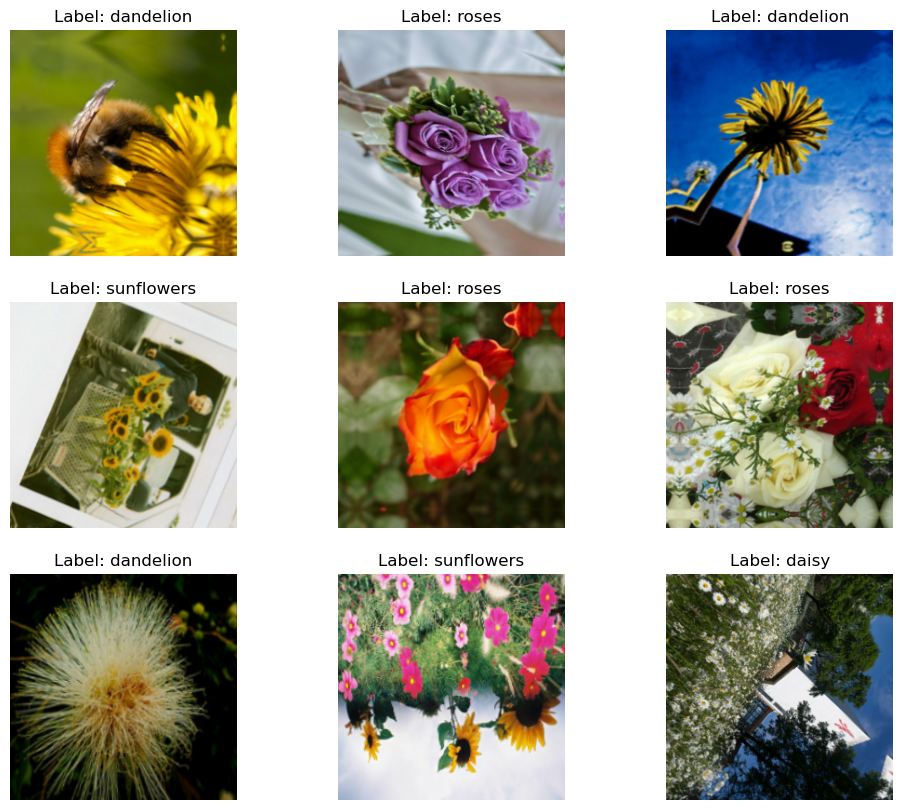

In [19]:
show_dataset_images(train_dataset)

In [20]:
validation_dataset = transform_images(validation_images, validation_labels)

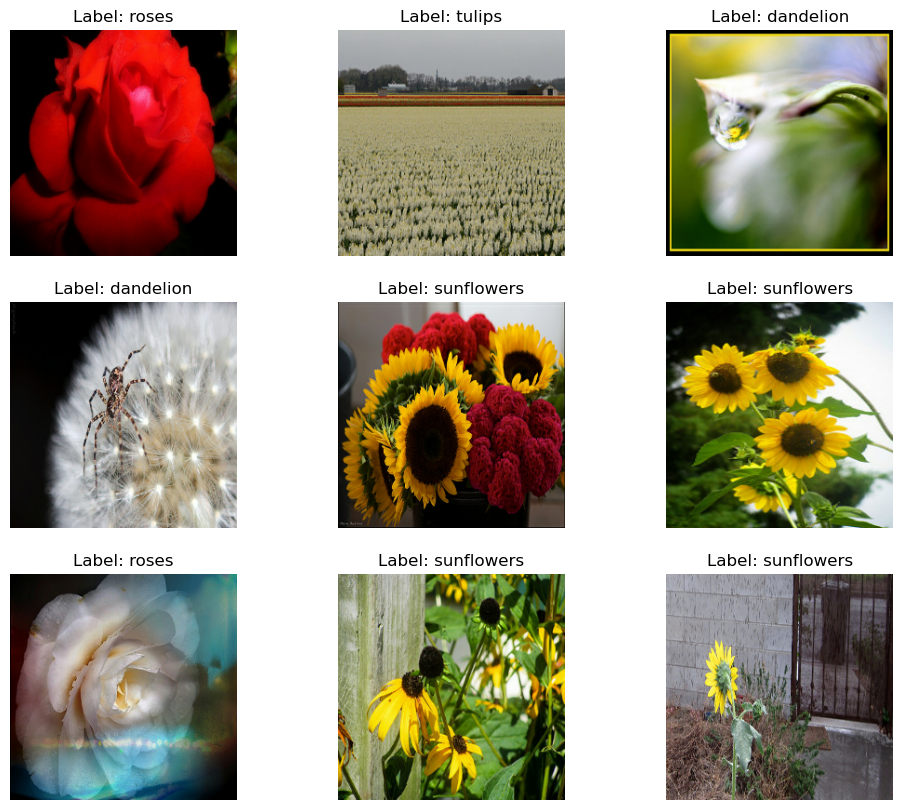

In [21]:
show_dataset_images(validation_dataset)

In [22]:
test_dataset = transform_images(test_images, test_labels)

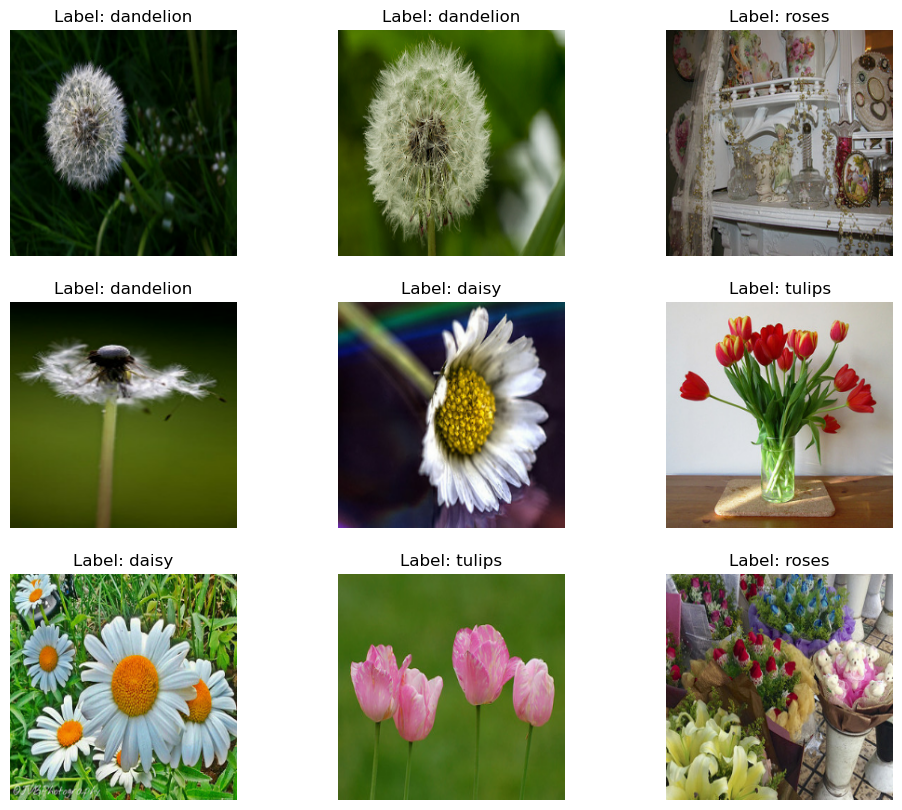

In [23]:
show_dataset_images(test_dataset)

### Batching

In [24]:
batch_size = 16

In [25]:
# shuffling the data set to ensure training model does not learn any unintended patterns due to the order of the data
# Prefetching improves the efficiency of data loading by overlapping the data preprocessing and model training.
train_set = train_dataset.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [26]:
valid_set = validation_dataset.batch(batch_size)
test_set = test_dataset.batch(batch_size)

## Model1: Freeze the weights for all layers for VGG16

In [27]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
base_model.trainable = False  # Freeze the base model

# Add custom top layers for the specific task
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6119 - loss: 11.5949 - val_accuracy: 0.7727 - val_loss: 0.8871
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.6988 - loss: 0.9305 - val_accuracy: 0.8136 - val_loss: 0.7454
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.7415 - loss: 0.7792 - val_accuracy: 0.8000 - val_loss: 0.7304
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7575 - loss: 0.7860 - val_accuracy: 0.8091 - val_loss: 0.7156
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.7652 - loss: 0.6912 - val_accuracy: 0.8341 - val_loss: 0.7042


In [28]:
def show_loss_accuracy(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting the loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the accuracy
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

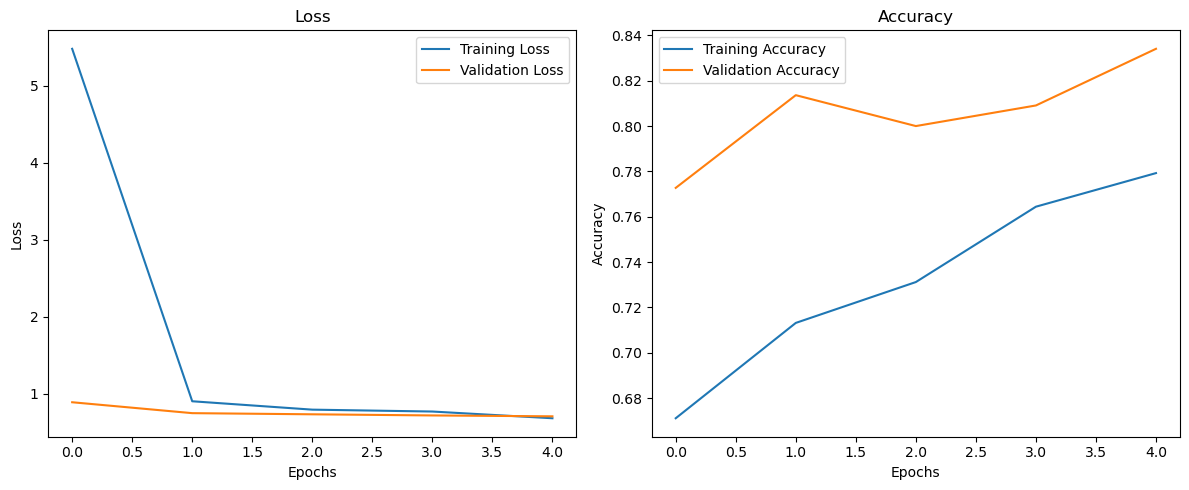

In [29]:
show_loss_accuracy(history)

In [30]:
from sklearn.metrics import classification_report,confusion_matrix

def show_predictions(model):
    pred_probabilities = model.predict(test_set)
    predictions = np.argmax(pred_probabilities, axis=1)
    predictions_str = [class_names[index] for index in predictions]
    print(classification_report(test_labels, predictions_str))

In [31]:
# validate against test_dataset

show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 930ms/step
              precision    recall  f1-score   support

       daisy       0.79      0.87      0.83       127
   dandelion       0.91      0.87      0.89       179
       roses       0.90      0.63      0.74       128
  sunflowers       0.86      0.81      0.84       140
      tulips       0.70      0.87      0.78       160

    accuracy                           0.82       734
   macro avg       0.83      0.81      0.81       734
weighted avg       0.83      0.82      0.82       734



## Hyper-parameters Tunning

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import keras_tuner as kt

def build_model(hp):
    base_model = VGG16(weights="imagenet", include_top=False)
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    
    # Tune the number of units in the Dense layer
    hp_units = hp.Int('units', min_value=256, max_value=1024, step=256)
    model.add(layers.Dense(units=hp_units, activation='relu'))
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.6, step=0.3)
    model.add(layers.Dropout(rate=hp_dropout))
    
    model.add(layers.Dense(5, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [33]:
dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\flower_photos'

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory=dir,
    project_name='assign_2'
)

Reloading Tuner from C:\Users\kaizi\Desktop\jupyter\DeepLearning\flower_photos\assign_2\tuner0.json


In [34]:
tuner.search(train_set, validation_data=valid_set, epochs=5)

In [35]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [36]:
print(f"""
The optimal number of units in the dense layer is {best_hps.get('units')}.
The optimal dropout rate is {best_hps.get('dropout')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


The optimal number of units in the dense layer is 1024.
The optimal dropout rate is 0.0.
The optimal learning rate for the optimizer is 0.001.



### Rebuild model with the Optimized Hyperparameters

In [37]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False)
base_model.trainable = False  # Freeze the base model

# Add custom top layers for the specific task
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6340 - loss: 17.5013 - val_accuracy: 0.8045 - val_loss: 0.7958
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.7806 - loss: 0.7336 - val_accuracy: 0.8205 - val_loss: 0.8509
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8280 - loss: 0.5817 - val_accuracy: 0.8182 - val_loss: 0.7532
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8483 - loss: 0.4939 - val_accuracy: 0.8273 - val_loss: 0.7907
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8480 - loss: 0.5460 - val_accuracy: 0.8636 - val_loss: 0.6654


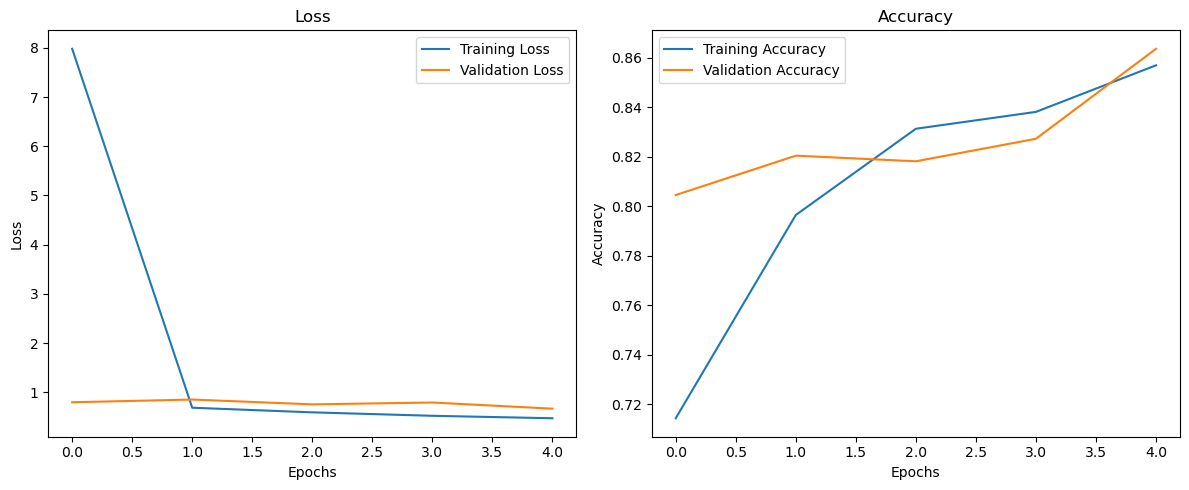

In [38]:
show_loss_accuracy(history)

In [39]:
# validate against test_dataset
show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 920ms/step
              precision    recall  f1-score   support

       daisy       0.90      0.84      0.87       127
   dandelion       0.90      0.89      0.90       179
       roses       0.82      0.80      0.81       128
  sunflowers       0.82      0.89      0.85       140
      tulips       0.79      0.79      0.79       160

    accuracy                           0.84       734
   macro avg       0.84      0.84      0.84       734
weighted avg       0.85      0.84      0.84       734



## Exam the VGG16 model architecture

In [40]:
# number of layers in VGG16 mode
num_layers = len(base_model.layers)
print(f"Number of layers in model: {num_layers}")

Number of layers in model: 19


In [41]:
# Print the layers of the base_model
for indices in zip(range(10), range(10, 19)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_4          10: block3_pool           
  1: block1_conv1           11: block4_conv1          
  2: block1_conv2           12: block4_conv2          
  3: block1_pool            13: block4_conv3          
  4: block2_conv1           14: block4_pool           
  5: block2_conv2           15: block5_conv1          
  6: block2_pool            16: block5_conv2          
  7: block3_conv1           17: block5_conv3          
  8: block3_conv2           18: block5_pool           


## Model2: unfreeze the last block of VGG16 (block 5)

In [42]:
base_model.trainable = False

# Unfreeze the last 4 layers (block5)
for layer in base_model.layers[15:]:
    print(f"{layer.name} -> unfreezed")
    layer.trainable = True

block5_conv1 -> unfreezed
block5_conv2 -> unfreezed
block5_conv3 -> unfreezed
block5_pool -> unfreezed


In [43]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.8823 - loss: 0.3464 - val_accuracy: 0.8864 - val_loss: 0.5888
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9158 - loss: 0.2493 - val_accuracy: 0.8841 - val_loss: 0.5255
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9306 - loss: 0.2074 - val_accuracy: 0.8909 - val_loss: 0.4982
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9281 - loss: 0.2063 - val_accuracy: 0.9000 - val_loss: 0.4220
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.9355 - loss: 0.1665 - val_accuracy: 0.8932 - val_loss: 0.4860


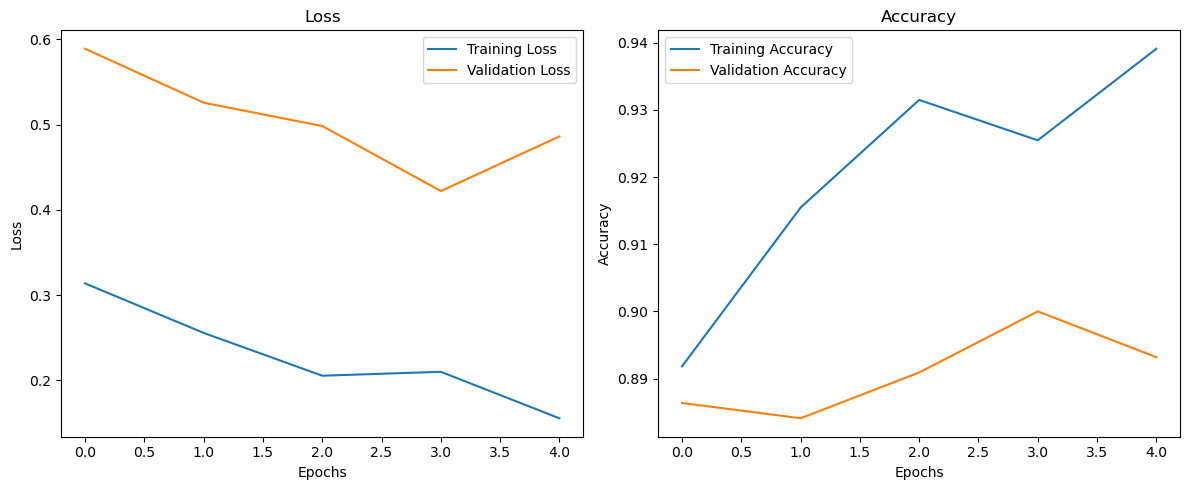

In [44]:
show_loss_accuracy(history)

In [45]:
show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 44s 949ms/step
              precision    recall  f1-score   support

       daisy       0.95      0.96      0.95       127
   dandelion       0.94      0.94      0.94       179
       roses       0.84      0.88      0.86       128
  sunflowers       0.94      0.91      0.92       140
      tulips       0.86      0.84      0.85       160

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



## Model3: unfreeze the all layers

In [46]:
base_model.trainable = True

In [47]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_set, validation_data=valid_set, epochs=15)

Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 738s 5s/step - accuracy: 0.9134 - loss: 0.2355 - val_accuracy: 0.8886 - val_loss: 0.3749
Epoch 2/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 731s 5s/step - accuracy: 0.9164 - loss: 0.2284 - val_accuracy: 0.9000 - val_loss: 0.3730
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 728s 5s/step - accuracy: 0.9480 - loss: 0.1492 - val_accuracy: 0.9091 - val_loss: 0.3086
Epoch 4/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 732s 5s/step - accuracy: 0.9457 - loss: 0.1579 - val_accuracy: 0.8932 - val_loss: 0.3618
Epoch 5/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 730s 5s/step - accuracy: 0.9454 - loss: 0.1709 - val_accuracy: 0.9045 - val_loss: 0.2934
Epoch 6/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 733s 5s/step - accuracy: 0.9575 - loss: 0.1039 - val_accuracy: 0.9136 - val_loss: 0.3239
Epoch 7/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 729s 5s/step - accuracy: 0.9586 - loss: 0.1286 - val_accuracy: 0.8909 - val_loss: 0.3302
Epoch 8/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 730s 5s/step - accuracy: 0.9506 - loss: 0.1433 - val_accu

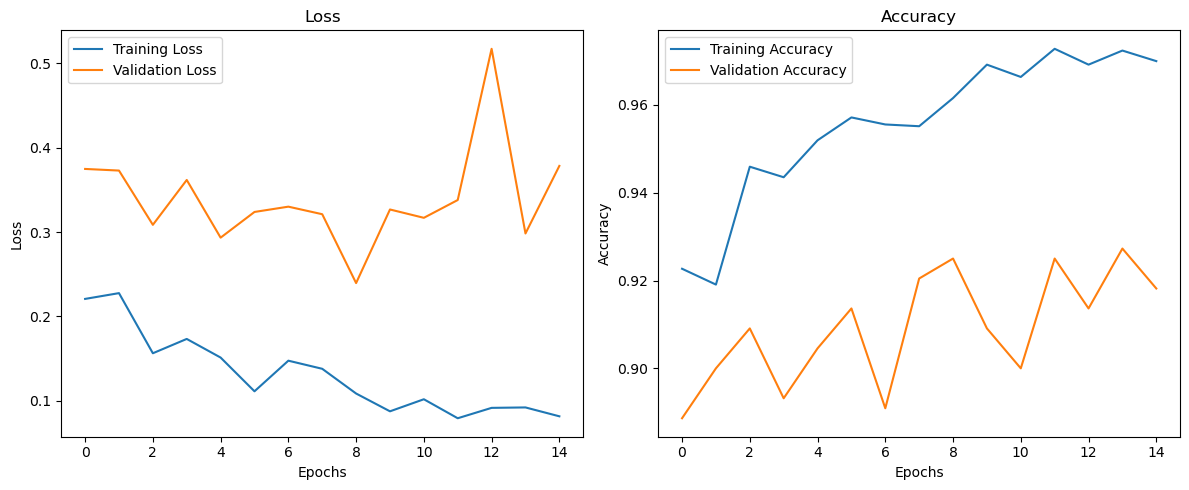

In [48]:
show_loss_accuracy(history)

In [49]:
show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 922ms/step
              precision    recall  f1-score   support

       daisy       0.95      0.90      0.92       127
   dandelion       0.88      0.96      0.92       179
       roses       0.87      0.92      0.90       128
  sunflowers       0.96      0.88      0.92       140
      tulips       0.90      0.89      0.90       160

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



Progressive unfreezing approach balances the retention of general features learned from a large, diverse dataset (ImageNet) with the need to adapt to the current dataset. It ensures that the model gradually learns task-specific features while maintaining the stability and generalization capabilities provided by the pre-trained weights. I see progressive improvement of f1-score from Model1 to Model3. the improvement in accuracy also significantly benefits from having more accumulated training epochs over time.